#Problem Formulation
Let $(\Omega, \mathcal{F}, P)$ be a fixed probability space on which an adapted stochastic process is defined $X=(X_t)_{0 \leq t \leq T}$ whose natural filtration is $(\mathcal{F}_t^0 := \sigma \{ X_s, s \leq t \})_{0 \leq t \leq T}$. Let $\mathbf{F}=(\mathcal{F}_0)_{0 \leq t \leq t}$ be the complete filtration of $(\mathcal{F}_t^0 := \sigma \{ X_s, s \leq t \})_{0 \leq t \leq T}$. with $P$-null sets of $\mathcal{F}$.

The stochastic process $X$ is $\mathbb{R}^d$-valued and represents the market price of $d$ financial assets (Bermudan call options) that influence the production of power. Assume $(X^i)_{i=1}^d$ follows a geometric Brownian motion satisfying the SDE:
\begin{equation}
dX_t = b_{I_t}X_tdt + \sigma_{I_t}X_tdW_t
\end{equation}
where $W$ is a standard Brownian otion on a filtered probability space $(\Omega, \mathcal{F}, \mathbf{F}=(\mathcal{F}_t)_{t \geq 0} P)$ and $I_t$ is the indicator variable of the regimes valued in $\mathbf{I}_d = \{1, \ldots, d \}$. $b_i \in \mathbf{R}$ and $\sigma_i >0$ are the drift and volatility of the system $X$ once in regime $I_t=i$ at time $t$.

We will consider a discrete approximization (Euler schema) with respect to. For $i = 1, \ldots, d$ we simulate $p$ paths
\begin{equation}
X^p_{n,i} = \exp \Big\{ \sum_{k=0}^n \big( (b-\sigma^2_i /2)_{\mathbf{I}}\bigtriangleup t + \sigma_{i, \mathbf{I}} \sqrt{\bigtriangleup t} \cdot Z_{k, i}^p \big)     \Big\}
\end{equation}
where $\bigtriangleup t = T/N$ and $Z_{k, i}^{p} \sim \mathcal{N} (0,1)$.



In [ ]:
import numpy as np
import torch
import torch.nn as nn
np.random.seed(234198)
import itertools
import random
import time
import scipy.stats
import math
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as tdata

In [ ]:
''' 
underlying process - Geometric brownian motion
'''

class GBM:
  def __init__(self, drift, sigma, delta, spot, assets,  paths, periods,
         maturity, dividend=0):
    self.drift = drift - dividend
    self.sigma = sigma
    self.delta = delta
    self.spot = spot
    self.assets = assets
    self.paths = paths
    self.periods = periods
    self.maturity = maturity
    self.dt = self.maturity / self.periods
    self.df = math.exp(-drift * self.dt)

  def simulate_process(self):
    """Returns array of dimension (paths x periods x assets) """
    paths = self.paths
    path = np.array([self.simulate_one_path() for i in range(paths)]) 
    return path.reshape(path.shape[0], path.shape[2], path.shape[1])

  def drift_fct(self,x):
    return  (self.drift-self.delta-0.5*self.sigma**2)* x

  def diffusion_fct(self,x):
    return self.sigma * x


  def simulate_one_path(self):
    ''' if a single path '''
    path = np.empty((self.assets, self.periods+1))
    path[:, 0] = self.spot
    for k in range(1, self.periods+1):
      random_numbers = np.random.normal(0, 1, self.assets)
      dW =(random_numbers*np.sqrt(self.dt))
      previous_spots = path[:, k - 1]
      diffusion = (self.diffusion_fct(previous_spots))
      path[:, k] = (
          previous_spots
          + self.drift_fct(previous_spots)* self.dt
          + diffusion*dW) 
    return path   

As introduced, the stochastic system can operate in $m$ modes or regimes from the finite set $\mathbb{I}=\{1, \ldots , m \}$. In this case we consider $m=2$ with $\mathbb{I}=\{\text{on}, \text{off} \}$. 

The regimes can be switched at a sequence of stopping times over a finite horizon $[0, \ldots , T]$.

There is a payoff rate per unit of time when the system is in mode $i \in \mathbb{I}$ at time $t$ as a mapping $\Psi_i(t, X_t): \Omega \times [0, T] \rightarrow \mathbb{R}$. The payoff function for the call option used is of the form $( \max_{i \in \{ 1, \ldots , d \}} X_t^i - K) ^{+}$, where $K$ is the strike price at any point in the time grid $0 = t_0 < t_1 < \ldots < t_N = T$. the system also outputs a final reward for being in mode $i \in \mathbb{I}$ at time $T$ given by $\Gamma_i$.

There is a cost for switching from regime $i$ to $j$ given by the function $\gamma_{i, j} : \Omega \times [0, T] \rightarrow \mathbb{R} $ to cover for the extra costs due to the change of the regime.

A strategy $\alpha$ for the power plant will be a combination of two sequences:
- non decreasing sequence of $\mathbb{F}$-stopping times $(\tau_n)_{n \geq 1}$, $n \in \mathbb{N} \backslash \{0\}$, where at $\tau_n$ the production is swithced from the current mode $i$ to $j$. we also assume: $\tau_0=t$ and $\tau_n \leq \tau_{n+1}$.
- a sequence of indicators $(\iota)_{n \geq 1}$, $n \in \mathbb{N} \backslash \{0\}$, $\mathcal{F}_{\tau_n}$- measurable valued in $\mathbb{I}_m$. At time $t=\tau_n$ the system is switched from the current regime $\iota_{n-1}$ to $\iota_{n}$, with $\iota_{0}=i$.

We denote by $\mathcal{A}_{t, i}$ the set of admissible strategies to switch at time $\tau_n$, $n \geq 1$, from the current regime $\iota_{n-1}$ to $\iota_{n}$. 


For any initial condition $(x, i) \in [0, T] \times \mathbb{I}_m$, and any control $\alpha=(\tau_n, \iota_n)_{n \leq 0} \in \mathcal{A}_{t, i}$. the total expected payoff up to $T$ for such strategy can be expressed as: 
\begin{equation}
J_i(x, \alpha) = \mathbb{E} \Big[ \sum_{s=t}^{T-1} \Psi(X_t^{x, i}, I_t^i) + \Gamma - \sum_{n \leq 1}\gamma_{\iota_{n-1}, \iota_n} \mathbf{1}_{ \{ \tau_n < T \} }  | \mathcal{F}_n   \Big]
\end{equation}

The objective is to maximize this expected total profit for all strategies $\alpha$. For this purpose, we set the value function:
\begin{equation}
V_i(x)=\sup_{\alpha \in \mathcal{A}} J_i(x, \alpha) \;\;\;\;\;\;\;\;\; \forall \alpha \in \mathcal{A}_{t, i} \,\, \mathbb{P}\; a.s. 
\end{equation}

Following Becker, Cheridito and Jentzen, we reformulate stopping time problem into a sequence of $0-1$ stopping decisions. To optimally stop the Markov process $X$ we make stopping decisions according to $f_n(X_n)$ for measurable functions $f_n: \mathbb{R}^d → \{0, 1 \}, n \in \mathbb{N}$. By construction $f_N \equiv 1$ as at $n=N$ there is a terminal stopping decision where $\tau_N \equiv N$. 

Given $n \in \{0, 1, \ldots, N-1 \}$ and the final stopping decision, let $\tau_{n+1}$ be a stopping time in $\mathcal{T}_{n+1}$ of the form:
\begin{equation}
\tau_{n+1} = \sum_{m=n+1}^N m f_m(X_m) \prod _{j=n+1}^{m-1} (1-f_j(X_j))
\end{equation}


To approach the problem, we iteratively approximate the optimal stopping decisions $f_n: \mathbb{R}^d \rightarrow \{0, 1 \}, n = \{ 1, 2, \ldots, N-1 \}$, by a neural network $f^{\theta}: \mathbb{R}^d \rightarrow \{0, 1 \}$ with parameter $\theta \in \mathbb{R}^q$. We choose $\theta_N \in \mathbb{R}^q$ such that $f^{\theta}_N \equiv 1$ and determine $\theta_n \in \mathbb{R}^q$ for $n \leq N-1$ by recursion of the form:

\begin{equation}
\tau_{n+1} = \sum_{m=n+1}^N m f^{\theta_m}(X_m) \prod _{j=n+1}^{m-1} (1-f^{\theta_j}(X_j))
\end{equation}

Since $f^{\theta}$ takes values in $\{ 0,1 \}$, hence not appropriate for a gradient-descent optimization method, the neural network includes a layer performing a logostic transformation such that we have the resulting output function $F^{\theta}: \mathbb{R}^d \rightarrow (0,1)$.

The Neural network includes $(d+40)$ hidden units and comprises a combination of linear and rectified linear activation functions. 

In [ ]:
'''
Neural network
'''

class Ftheta_NN(nn.Module):
  def __init__(self, assets, hidden_size):
    super(Ftheta_NN, self).__init__()
    self.l1 = nn.Linear(assets, hidden_size) 
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, hidden_size)
    self.l3 = nn.Linear(hidden_size, 1)  
    self.sigmoid=nn.Sigmoid()
    
  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    out = self.sigmoid(out)

    return out



# set initial weights of a linear layer of the NN with uniform values and bias=0.01 (or choose zero initial weights)
def init_weights(m):
  if isinstance(m, torch.nn.Linear):
    torch.manual_seed(42)
    # torch.nn.init.zeros_(m.weight)
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

In [ ]:
'''
Train the neural network
'''

class Train_Network(object):

  def __init__(self, assets, paths, hidden_size, epochs=20, batch_size=2000):
    self.assets = assets
    self.paths = paths
    self.epochs = epochs
    self.batch_size = batch_size
    self.network = Ftheta_NN(self.assets, hidden_size=self.assets+40).double()
    self.network.apply(init_weights)

  def _Loss(self, X):
    return -torch.mean(X)

  def train_network(self,  stock_values, immediate_exercise_value,
                    discounted_next_values):
    optimizer = optim.Adam(self.network.parameters())
    discounted_next_values = torch.from_numpy(discounted_next_values).double()
    immediate_exercise_value = torch.from_numpy(immediate_exercise_value).double()
    inputs = stock_values
    X_inputs = torch.from_numpy(inputs).double()

    self.network.train(True)
    ones = torch.ones(len(discounted_next_values))
    for epoch in range(self.epochs):
      for batch in tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=self.batch_size, drop_last=False):

        optimizer.zero_grad()
        outputs = self.network(X_inputs[batch]).reshape(-1) # probabilities
        values = (immediate_exercise_value[batch].reshape(-1)[0] * outputs +
                    discounted_next_values[batch] * (ones[batch] - outputs))
        loss = self._Loss(values)
        loss.backward()
        optimizer.step()

  def evaluate_network(self, X_inputs):
    self.network.train(False)
    X_inputs = torch.from_numpy(X_inputs).double()
    outputs = self.network(X_inputs)
    return outputs.view(X_inputs.size()[0]).detach().numpy()

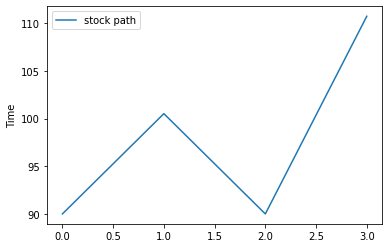

[[[ 90.          95.5953999  105.61843508 111.22060835  90.
   102.64972517 115.82297642 126.45137768  90.          97.19614849]
  [100.52157754 112.16534216  90.          97.0034381  108.14743016
   113.5713288   90.         102.071225   110.18659785 110.94685601]
  [ 90.         105.51902094 117.28957928 128.49902562  90.
    96.34354252 105.64229116 125.55769572  90.          92.83609216]
  [110.74424711 124.4784162   90.          96.39304493 112.67626621
   124.15463253  90.          90.76548998  94.35817489 105.26685185]]

 [[ 90.          97.62912614 110.28224834 131.02165233  90.
    91.92754984  95.62085035  96.84716797  90.         100.06142597]
  [117.25489293 133.89927321  90.          95.05423536  99.53732046
   119.11885552  90.          99.81249097 106.513045   122.40302335]
  [ 90.          94.63521195 107.58510208 127.48152043  90.
    89.462402   100.07329749 102.97763526  90.          94.74477467]
  [109.43287432 123.71956637  90.          99.07684124 114.1327272
   1

In [ ]:
# generate underlying stochastic process
_STOCK_MODELS = {"BlackScholes": GBM,}
hyperparam_test_stock_models = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':4, 'periods': 3, 'maturity': 3., 'assets':10,  'spot':90,}
stock_model_switching = _STOCK_MODELS["BlackScholes"](**hyperparam_test_stock_models)
drift= 0.2; sigma= 0.05; delta= 0.1; paths=1; periods=3; maturity= 3; assets=1; spot=90; regime=2; strike=90
disc_factor = np.math.exp((-drift) * maturity/(periods))
stock_paths = stock_model_switching.simulate_process() # shape (1, 4, 1)

def draw_stock_model(stockmodel):
    stock_paths = stockmodel

    # draw a path
    one_path = stock_paths[0, :, 0]
    dates = np.array([i for i in range(len(one_path))])
    plt.plot(dates, one_path, label='stock path')
    plt.ylabel('Stock price')
    plt.ylabel('Time')
    plt.legend()
    return plt.show()   

draw_stock_model(stock_paths)    
print(stock_paths)

In [ ]:
'''
Define a function gamma(i, j) for the switching cost
'''

def switching_cost(payoff, eta = 0.02):
  cost = np.array([np.sqrt(eta*payoff)+np.tanh(eta)*np.sqrt(eta*payoff)+np.random.randn(), np.sqrt(eta*payoff)+np.tanh(eta)+np.random.randn()])
  return cost     

'''
Define an objective function
'''

def objective_f(X,Y, tau, disc_factor, date, path):
  Y=X*np.exp((date-tau)*disc_factor) + Y[date+1, path,:]- np.squeeze(switching_cost(X), axis=(1,)) 
  return Y  

'''
Define a payoff function
[more options can be set]
'''

class Eval:
  def payoff(self, X):
    raise NotImplemented()

class MaxCall(Eval):
  def __init__(self, strike):
    self.strike =  strike

  def payoff(self, X):
    payoff = np.max(X, axis=1) - self.strike
    return payoff.clip(0, None) 

class RunningBenefit(Eval):

  def objective_f(X,Y, tau, disc_factor, date, path):
    Y=X*np.exp((date-tau)*disc_factor) + Y[date+1, path,:]- np.squeeze(switching_cost(X), axis=(1,)) 
    return Y  




Consider the cases of intermediate time steps $t_0, t_1, t_2$
- at $t=3$

- at $t=2$:
  - produce a stopping rule at t2
  - update f_theta and tau
  - if F_theta = 1:
    - compute 
  
$$ Y_{i,2} = \Psi_i(2) + \max[ Y_{j,2} - \gamma_{i,j}(2) ] $$ <br>
$$ Y_{j,2} = \Psi_j(2) + \max [ Y_{i,2} - \gamma_{j,i}(2) ] $$

  - if $F_{\theta} = 0$:
    - compute $Y_{i,2} = \Psi_i(2)$ and $Y_{j,2} = \Psi_j(2)$

- at $t=1$, $t=0$ the same <br>

$\Psi_{i,j}(t)=$ running benefit function -> payoff function  <br>
$\gamma_{i,j}(t) =$ switching cost function -> what?                       


In [ ]:
class Recursive:
  def __init__(self, process, eval, epochs=20,  hidden_size=10):

    self.process = process

    payoff="MaxCall"          
    runningbenefit = "RunningBenefit"
    self.payoff = eval[payoff](strike)
    self.runningbenefit = eval[runningbenefit]


    state_size = process.assets
    self.neural_stopping = Train_Network(state_size, process.paths, hidden_size=hidden_size)

  def price(self):
    """It computes the price of an American Option using a backward recusrion.
    """
    process = self.process
    stock_paths = self.process.simulate_process()
    
    disc_factor = np.math.exp((-process.drift) * process.maturity/(process.periods))
    
    ''' 
    create empty objects to store values 
    '''
    # Vmat will contain value function estimates
    # value function estimate should distinguish the two types of regimes too
    Y_it=np.zeros((periods+1,paths, regime))
    #print("shape Y_it",Y_it.shape) #(4, 1, 2)
    # Y_it will take mean of Y_it estimates across paths (for each regime)
    Y_it_mean=np.zeros((periods+1, regime))
    Y_it_std = np.zeros((periods+1, regime))
    #print("shape Y_it_est",Y_it_estimate.shape) #(4, 2)

    # Fmatrix records stopping decisions 
    F_theta=np.zeros((periods+1,paths, regime))
    F_theta[periods,:,:]=1 # at maturity we switch
    #print("f_theta ",f_theta.shape) #(4, 1, 2)

    #tau matrix will record stopping times, at maturity we assume the process stops
    # once a stopping decision is recorded, we take the time at which the stopping decision occured (hence the stopping time)
    tau_list=np.zeros((periods+1,paths, regime))
    tau_list[periods,:,:]=periods

    # for N=N
    payoff_N = self.payoff.payoff(stock_paths[:, -1, :]) # payoff of the last date --- \gamma_i or \gamma_j
    payoff_0 = self.payoff.payoff(stock_paths[:, 0, :])  #[0] #initial payoff   
    payoff_N =np.reshape(np.repeat(payoff_N, 2, axis=0),(process.paths,2)) 

    Y_it[periods,:,:]=payoff_N*disc_factor*periods #PV terminal exercise price
    Y_it_mean[periods]=np.mean(Y_it[periods,:,:])
    values = payoff_N


    # recursive calc, from n=N-1 to 0 with steps of -1


    for date in range(stock_paths.shape[1] - 2, 0, -1):
      f_theta = self.switch(stock_paths[:, date, :],
                            payoff_N.reshape(-1, 1), 
                            values*disc_factor)
      F_theta[date,:,:]=(f_theta > 0.5)*1.0   # 0-1 decision
      tau_list[date,:,:]=np.argmax(F_theta, axis=0)

      for path in range(0, paths):
        
        tau = tau_list[date,path,:]
        running_benefit = self.payoff.payoff(np.expand_dims(stock_paths[path, int(tau[0]), :], axis=0))
        Y_it[date,path:]=self.runningbenefit.objective_f(running_benefit, Y_it, int(tau[0]), disc_factor, date, path)
      
      Y_it_mean=np.mean(Y_it, axis=1) # mean by row of the paths
      Y_it_std=np.std(Y_it, axis=1) # std by row of the paths



      
      #maxi = np.max(np.array([np.mean(payoff_0), np.mean(Y_it_mean, axis=0)]))  
      spot_payoff = np.mean(payoff_0)
    return {'mean': np.mean(Y_it_mean, axis=0), 'sd':  np.mean(Y_it_mean, axis=0),'SE': np.mean(Y_it_mean, axis=0)/(np.sqrt(process.paths)), 'spot_payoff' : spot_payoff, 'estimates' : Y_it }


  def switch(self, inputs, immediate_exercise_values,
           discounted_next_values):
    self.neural_stopping.train_network(
        inputs,
        immediate_exercise_values.reshape(-1, 1),
        discounted_next_values)

    switch = self.neural_stopping.evaluate_network(inputs)
    return switch      

  def switching_cost(payoff, eta = 0.02):
    cost = np.array([np.sqrt(eta*payoff)+np.tanh(eta)*np.sqrt(eta*payoff)+np.random.randn(), np.sqrt(eta*payoff)+np.tanh(eta)+np.random.randn()])
    return cost    




In [ ]:
paths=hyperparam_test_stock_models['paths']
drift=hyperparam_test_stock_models['drift']
spot=hyperparam_test_stock_models['spot']
sigma=hyperparam_test_stock_models['sigma']
maturity=hyperparam_test_stock_models['maturity']
assets=hyperparam_test_stock_models['assets']
periods=hyperparam_test_stock_models['periods']
strike=90


epochs=10
hidden_size=10

_EVAL = {"MaxCall": MaxCall,
            "RunningBenefit": RunningBenefit,
           }

_ALGOS = {"DOS": Recursive, 
          }
algo="DOS"
payoff="MaxCall"

_PAYOFFS = {"MaxCall": MaxCall,
           }
        
payoff_ = _PAYOFFS[payoff](strike)
pricing = _ALGOS[algo](stock_model_switching, _EVAL, epochs=epochs,hidden_size=hidden_size)

In [ ]:
price_switch = pricing.price()


RuntimeError: ignored

In [ ]:
# extract the objects

Mean_est_dos = 'mean'
Sd_est_dos = 'sd'
SE_est_dos = 'SE'
pay0_dos = 'spot_payoff'
matrix = 'matrix'

Mean_estimate_dos = price_switch.get(Mean_est_dos, 0)
Sd_estimate_dos = price_switch.get(Sd_est_dos, 0)
SE_estimate_dos = price_switch.get(SE_est_dos, 0)
payoff0_dos = price_switch.get(pay0_dos, 0)
matrix_results = price_switch.get(matrix)

z=scipy.stats.norm.ppf(0.975)
lower=Mean_estimate_dos - z*Sd_estimate_dos
upper=Mean_estimate_dos + z*Sd_estimate_dos

dates = np.array([i for i in range(len(Mean_estimate_dos))])
fig, ax = plt.subplots()
ax.plot(dates,Mean_estimate_dos)
ax.fill_between(dates, (Mean_estimate_dos-z*Sd_estimate_dos), (Mean_estimate_dos+z*Sd_estimate_dos), color='b', alpha=.1)
plt.xlabel("Dates")
plt.ylabel("Value")

print(matrix_results)

In [ ]:
def switch(inputs, immediate_exercise_values,
           discounted_next_values):
    neural_stopping.train_network(
        inputs,
        immediate_exercise_values.reshape(-1, 1),
        discounted_next_values)

    switch = neural_stopping.evaluate_network(inputs)
    return switch




In [ ]:
# open up the code, some things are not working
# first make it work for paths>1

# Vmat will contain value function estimates
# value function estimate should distinguish the two types of regimes too
Y_it=np.zeros((periods+1,paths, regime))
#print("shape Y_it",Y_it) #(4, 4, 2)
# Y_it will take mean of Y_it estimates across paths (for each regime)
Y_it_mean=np.zeros((periods+1, regime))
Y_it_std = np.zeros((periods+1, regime))
#print("shape Y_it_est",Y_it_estimate.shape) #(4, 2)

# Fmatrix records stopping decisions 
F_theta=np.zeros((periods+1,paths, regime))
F_theta[periods,:,:]=1 # at maturity we switch
#print("f_theta ",f_theta.shape) #(4, 1, 2)

#tau matrix will record stopping times, at maturity we assume the process stops
# once a stopping decision is recorded, we take the time at which the stopping decision occured (hence the stopping time)
tau_list=np.zeros((periods+1,paths, regime))
tau_list[periods,:,:]=periods

process = _STOCK_MODELS["BlackScholes"](**hyperparam_test_stock_models)
stock_paths = process.simulate_process()
_EVAL = {"MaxCall": MaxCall,
            "RunningBenefit": RunningBenefit,
           }
payoff="MaxCall"          
runningbenefit = "RunningBenefit"
payoff = _EVAL[payoff](strike)
runningbenefit = _EVAL[runningbenefit]
state_size = process.assets
neural_stopping = OptimalStoppingOptimization(state_size, process.paths, hidden_size=hidden_size) 

# for N=N
payoff_N = payoff.payoff(stock_paths[:, -1, :]) # payoff of the last date --- \gamma_i or \gamma_j
payoff_0 = payoff.payoff(stock_paths[:, 0, :])  #[0] #initial payoff   
payoff_N =np.reshape(np.repeat(payoff_N, 2, axis=0),(process.paths,2))

Y_it[periods,:,:]=payoff_N*disc_factor*periods #PV terminal exercise price
Y_it_mean[periods]=np.mean(Y_it[periods,:,:])
values = payoff_N
print(values)

# for smaller n
date=2
print(stock_paths[:, date, :])
print(stock_paths)

network = NetworkDOS(process.assets, hidden_size=process.assets+40).double()
network.apply(init_weights)
optimizer = optim.Adam(network.parameters())
discounted_next_values = torch.from_numpy(payoff_N.reshape(-1, 1)).double()

immediate_exercise_value = torch.from_numpy(values*disc_factor).double()
print("immediate", immediate_exercise_value)
inputs = stock_paths[:, date, :]
X_inputs = torch.from_numpy(inputs).double() #just a tensor


network.train(True)
ones = torch.ones(len(discounted_next_values))
batch_size=200


batch=2
epoch=3


optimizer.zero_grad()
outputs = network(X_inputs[batch]).reshape(-1) # probabilities
values = (immediate_exercise_value[batch].reshape(-1) * outputs +
            discounted_next_values[batch] * (ones[batch] - outputs))
print(immediate_exercise_value[batch].reshape(-1)*outputs)
print(immediate_exercise_value[batch].reshape(-1)[0]*outputs)

print(discounted_next_values[batch].size)
print((ones[batch] - outputs).size)
#print("values", values)

'''
for date in range(stock_paths.shape[1] - 2, 0, -1):
  f_theta = switch(stock_paths[:, date, :],
                        payoff_N.reshape(-1, 1), 
                        values*disc_factor)
  F_theta[date,:,:]=(f_theta > 0.5)*1.0   # 0-1 decision
  tau_list[date,:,:]=np.argmax(F_theta, axis=0)

  for path in range(0, paths):
    
    tau = tau_list[date,path,:]
    running_benefit = payoff.payoff(np.expand_dims(stock_paths[path, int(tau[0]), :], axis=0))
    Y_it[date,path:]= runningbenefit.objective_f(running_benefit, Y_it, int(tau[0]), disc_factor, date, path)
  
  Y_it_mean=np.mean(Y_it, axis=1) # mean by row of the paths
  Y_it_std=np.std(Y_it, axis=1) # std by row of the paths



  
  #maxi = np.max(np.array([np.mean(payoff_0), np.mean(Y_it_mean, axis=0)]))  
  spot_payoff = np.mean(payoff_0)

print("Ftheta", F_theta)
print("tau", tau)
print("tau_list", tau_list)
print("Y_it", Y_it)
print("Y_it_std",Y_it_std)
'''

In [ ]:
epochs=20; batch_size=2000
network = NetworkDOS(process.assets, hidden_size=process.assets+40).double()
network.apply(init_weights)

def train_network(stock_values, immediate_exercise_value,
                    discounted_next_values):
    optimizer = optim.Adam(network.parameters())
    discounted_next_values = torch.from_numpy(discounted_next_values).double()
    immediate_exercise_value = torch.from_numpy(immediate_exercise_value).double()
    inputs = stock_values
    X_inputs = torch.from_numpy(inputs).double()

    network.train(True)
    ones = torch.ones(len(discounted_next_values))
    for epoch in range(epochs):
      for batch in tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=batch_size, drop_last=False):

        optimizer.zero_grad()
        outputs = network(X_inputs[batch]).reshape(-1) # probabilities
        values = (immediate_exercise_value[batch].reshape(-1)[0] * outputs +
                    discounted_next_values[batch] * (ones[batch] - outputs))
        
        loss = -torch.mean(values)
        loss.backward()
        optimizer.step()

def evaluate_network(X_inputs):
  network.train(False)
  X_inputs = torch.from_numpy(X_inputs).double()
  outputs = network(X_inputs)
  return outputs.view(X_inputs.size()[0]).detach().numpy()


neural_stopping.train_network(
        stock_paths[:, date, :],
        payoff_N.reshape(-1, 1),
        values*disc_factor)
switch = neural_stopping.evaluate_network(stock_paths[:, date, :])  